# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

### Imports

In [174]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Globals
Defined here to make code a bit more readable

In [175]:
SAT_CHL_A_NAME = "chlor_a [mg m^-3] @ Dummy=first" 
BGC_CHL_A_NAME = "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0"

### Load & Format BGC Data

In [176]:
bgc_df = pd.read_csv("data/argo-isosurface-data.csv")
bgc_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
bgc_df.dropna(inplace=True) # Drop points missing chlorophyll values
bgc_df.drop_duplicates(inplace=True) # Drop duplicates (for some reason stations 1-9 like to duplicate)
bgc_df["Station Num"]=range(1,len(bgc_df)+1) # Add in column with station numbers
bgc_df[BGC_CHL_A_NAME]=bgc_df[BGC_CHL_A_NAME]/20. # Normalize chlorophyll data

bgc_df["Overall Day Num"] = bgc_df["Time [yr]"].astype(int) * 365 + bgc_df["Day of Year"] # Add in column with total days
bgc_df.head()

,Cruise,QV:ARGO,Station,QV:ARGO.1,Type,QV:ARGO.2,yyyy-mm-ddThh:mm:ss.sss,QV:ARGO.3,Longitude [degrees_east],QV:ARGO.4,...,QV:ARGO.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0,Station Num,Overall Day Num
1,5905108,0,1a_D_A_bio,0,C,0,2017-07-29T20:01:50,0,185.24200,0,...,0,1,0,185.242,-32.465,2017.57,210,0.598395,1,736415
3,5905108,0,2a_D_A_bio,0,C,0,2017-08-08T20:37:00,0,185.30000,0,...,0,1,0,185.300,-32.267,2017.60,220,0.628195,2,736425
5,5905108,0,3a_D_A_bio,0,C,0,2017-08-18T19:37:50,0,185.25600,0,...,0,1,0,185.256,-32.298,2017.63,230,0.415292,3,736435
7,5905108,0,4a_D_A_bio,0,C,0,2017-08-28T21:43:20,0,185.32600,0,...,0,1,0,185.326,-32.560,2017.66,240,0.514820,4,736445
9,5905108,0,5a_D_A_bio,0,C,0,2017-09-07T23:10:00,0,185.25101,0,...,0,1,0,185.251,-32.979,2017.68,250,0.363909,5,736455


### Load & Format Satellite Data

In [177]:
sat_data_dir = "data/satellite-data"

In [178]:
# Helper Functions
def loadSatelliteData(sat_data_dir):
    """Wrapper function for loading satellite data
    
    Args:
        sat_data_dir (str): string representing file location of all satellite data
    
    Returns:
        sat_df (DataFrame): pandas dataframe containing clean satellite data with chlA values
    """
    sat_df = pd.DataFrame()
    
    for f in glob.glob('%s/*.txt' % sat_data_dir): # Iterate through files in sat_data_dir
        year, day = parseFilenameDate(f)
        new_df = pd.read_csv(f, delimiter="\t",header=1)
        new_df["Time [yr]"] = int(year) # Add year to dataframe
        new_df["Day of Year"] = int(day) # Add day of year to dataframe
        sat_df = pd.concat([new_df, sat_df])
    
    sat_df.dropna(axis=1, how='all', inplace=True) # Remove unused columns
    sat_df.dropna(inplace=True) # Drop points missing chlorophyll values
    sat_df["Overall Day Num"] = sat_df["Time [yr]"].astype(int) * 365 + sat_df["Day of Year"] # Add in column with total days
    
    return sat_df

def parseFilenameDate(filename):
    """Parses satellite data filename for start date
    
    Args:
        filename (str): string representing filename
        
    Returns:
        year (int): year of data
        day (int): day of year of data
    """
    start_idx = filename.find("\V") + 2 #Each date starts with \V, and add 2 to move cursor over by /V
    year = filename[start_idx:start_idx + 4] #Year is 4 characters long 
    day = filename[start_idx + 4:start_idx + 7] #Day of year is 3 characters long

    return year, day

In [179]:
sat_df = loadSatelliteData(sat_data_dir)

In [180]:
sat_df.head()

,Cruise,QF,Station,QF.1,Type,QF.2,QF.3,Longitude [degrees_east],QF.4,Latitude [degrees_north],QF.5,QV:ODV:STATION,Dummy Var,Longitude,Latitude,Time [yr],Day of Year,chlor_a [mg m^-3] @ Dummy=first,Overall Day Num
0,V20173212017328.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,1,1,B,1,1,180.02083,1,-20.02083,1,1,0,-179.979,-20.0208,2017,321,0.115279,736526
1,V20173212017328.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,2,1,B,1,1,180.27083,1,-20.02083,1,1,0,-179.729,-20.0208,2017,321,0.109410,736526
23,V20173212017328.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,24,1,B,1,1,185.77083,1,-20.02083,1,1,0,-174.229,-20.0208,2017,321,0.072543,736526
25,V20173212017328.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,26,1,B,1,1,186.27083,1,-20.02083,1,1,0,-173.729,-20.0208,2017,321,0.114058,736526
26,V20173212017328.L3m_8D_SNPP_CHL.x_chlor_a.nc,1,27,1,B,1,1,186.52083,1,-20.02083,1,1,0,-173.479,-20.0208,2017,321,0.121907,736526


### Lookup Chl-A values
For each station in the BGC argo dataset, look up the nearest lat/long value within correct time period containing Chl-A data in the satellite dataset. Then create dataset to be plotted

In [181]:
# Helper Functions
def findNearestValue(lat, long, day_num, df):
    """Find satellite chl-A value for point closest to input point
    
    Args:
        lat (float): input latitude
        long (float): input longitude
        day_num (int): Overall day number of input point
        df (DataFrame): Pandas dataframe containing satellite data
    
    Returns:
        chl_A_value (float): chl-A value of nearest satellite data point
        nearest_lat (float): Latitiude of nearest data point
        nearest_long (float): Longitude of nearest data point
    """
    time_df = filterByTime(day_num, df)
    nearest_sat_df = findNearestPoint(lat, long, time_df)
    
    chl_A_value = nearest_sat_df[SAT_CHL_A_NAME]
    nearest_lat = nearest_sat_df["Latitude [degrees_north]"]
    nearest_long = nearest_sat_df["Longitude [degrees_east]"]
    
    if chl_A_value.count() == 0: # Check if no points were found
        return None, None, None
    else:
        return float(chl_A_value), float(nearest_lat), float(nearest_long)
    
def filterByTime(day_num, df):
    """Filter dataframe for only applicable time periods.
    
    Assumes satellite data has a column containing the first day number of 
    the time period it covers. We want to filter for the time period during which 
    the point was taken, so we want to find the closest day number in the dataset that 
    isn't larger than the input day number
    
    Args:
        day_num (int): Overall day number of input point
        df (DataFrame): Pandas dataframe containing satellite data
        
    Returns:
        time_df (DataFrame): Pandas dataframe containing time-filtered satellite data
    """
    # Find last satellite day number that is less than input day number
    closest_day = df["Overall Day Num"][day_num - df["Overall Day Num"] >=0].max()
    # Create bool array with values we want to keep and use it to filter out irrelevant timeframes
    time_df = df[df["Overall Day Num"]==closest_day]
    
    return time_df

def findNearestPoint(lat, long, df):
    """ Finds approximate nearest point - first searches latitude, 
    then searches longitude
    
    Doesn't truly find nearest point because that would be more complicated 
    but unneccessary since I'm assuming the data is rather grid-like
    
    Args:
        lat (float): Latitude of point to find in grid
        long (float): Longitude of point to find in grid
        df (DataFrame): pandas dataframe containing grid of satellite points
        
    Returns:
        nearest_chl_a (DataFrame): pandas dataframe containing nearest valid satellite station
    """
    
    lats = df["Latitude [degrees_north]"]

    nearest_lat_error = abs(lats-lat).min() # Compute error for nearest latitude point
    nearest_lat_idxs = abs(lats-lat) == nearest_lat_error # Create bool array where latitude matches
    lat_sat_df = df[nearest_lat_idxs] # Use bool array to filter for matching latitude

    longs = lat_sat_df["Longitude [degrees_east]"] # Only look at longitude within matching latitude set
    nearest_long_error = abs(longs-long).min()
    nearest_long_idxs = abs(longs-long) == nearest_long_error

    nearest_chl_a = lat_sat_df[nearest_long_idxs]
    
    return nearest_chl_a
#     nearest_pt = lat_sat_df[nearest_long_idxs][SAT_CHL_A_NAME]
    
#     if nearest_pt.count() == 0: # Check if no points were found
#         return None
#     else:
#         return float(nearest_pt)

### Create Compiled Dataset

In [182]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "BGC Lat": [],
                 "BGC Long": [],
                 "BGC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(bgc_df)): # For each station in BGC dataset
    stn = bgc_df.iloc[i] # Get BGC data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["BGC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["BGC Long"].append(long)
    
    # Fill in BGC Chl-A data
    bgc_chl = stn[BGC_CHL_A_NAME]
    compiled_dict["BGC Chl-A"].append(bgc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

compiled_df = pd.DataFrame(compiled_dict)
compiled_df.head()

,BGC Chl-A,BGC Lat,BGC Long,Overall Day Num,Sat Chl-A,Sat Lat,Sat Long,Station Num
0,0.598395,-32.465,185.24200,736415,NaN,NaN,NaN,1
1,0.628195,-32.267,185.30000,736425,NaN,NaN,NaN,2
2,0.415292,-32.298,185.25600,736435,0.216514,-32.27083,185.27083,3
3,0.514820,-32.560,185.32600,736445,0.189774,-32.52083,185.27083,4
4,0.363909,-32.979,185.25101,736455,0.184411,-33.02083,185.27083,5


### Plot Data
Objective: Create a plot that quantifies error between different Chl-A sensors

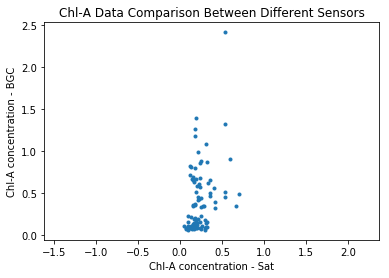

In [183]:
# TODO: Make this object-oriented
compiled_df = compiled_df.dropna() # TODO: make this better
plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')


# TODO: make this prettier 
# TODO: Finish converting .nc to .txt files
# compiled_df["Sat Chl-A"]
# compile2 = compiled_df.dropna() # Temporary - currently used to filter na values, will be fixed once all data is loaded
# plt.plot(compile2["Station Num"], compile2["Sat Chl-A"], '.')
# # compile2

plt.axis("equal")
plt.title("Chl-A Data Comparison Between Different Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - BGC")
# plt.legend(["BGC", "Satellite"])
# plt.xkcd()

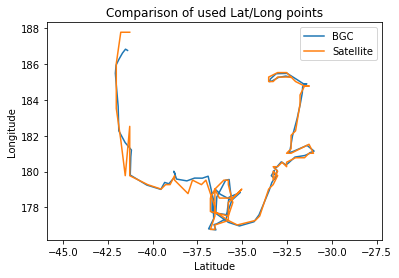

In [184]:
# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"])
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"])
plt.axis("equal")


plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend(["BGC", "Satellite"])
plt.title("Comparison of used Lat/Long points")

In [185]:
"""
In Wellington

Priority:
Figure out maps in python
Figure out .nc file opening
Get up to date satellite data 

Other:
Offline latex
Images

Papers:
Satellite sampling depth
Satellite resolution/exact sensors used
BGC sensors used
Our sensors


Notes:
Challenges? - in our area, lots of different levels of chlorophyll - makes it difficult to pinpoint - using most sensitive range, but it has three levels of sensitivity
Explain integration to 20 with figures

Publish code (put online + link ok)
Should include description of code (how it got there)
Find more literature on sensors to add to intro

Throw in figures - throw in "typical" profiles to verify 20 is valid

Data source should also go in methods

Questions:
Chl-a accuracy in papers? difficult to find
Previous cruise track data
B and C types in dataset
Surface data calibration

Figures:
Depth comparison of BGC & us?
"""


'\nIn Wellington\n\nPriority:\nFigure out maps in python\nFigure out .nc file opening\nGet up to date satellite data \n\nOther:\nOffline latex\nImages\n\nPapers:\nSatellite sampling depth\nSatellite resolution/exact sensors used\nBGC sensors used\nOur sensors\n\n\nNotes:\nChallenges? - in our area, lots of different levels of chlorophyll - makes it difficult to pinpoint - using most sensitive range, but it has three levels of sensitivity\nExplain integration to 20 with figures\n\nPublish code (put online + link ok)\nShould include description of code (how it got there)\nFind more literature on sensors to add to intro\n\nThrow in figures - throw in "typical" profiles to verify 20 is valid\n\nData source should also go in methods\n\nQuestions:\nChl-a accuracy in papers? difficult to find\nPrevious cruise track data\nB and C types in dataset\nSurface data calibration\n\nFigures:\nDepth comparison of BGC & us?\n'

### S290 Data

In [186]:
# Helper Functions 
def parseDateHC(timestamp):
    """Parses timestamp from hydrocast dataset and returns an 
    overall day number used to easily compare to BGC and satellite
    datasets.
    
    Args:
        timestamp (str): Timestamp in the format yyyy-mm-ddThh:mm:ss.sss
        
    Returns:
        day_num (int): Overall day number
    """
    days_in_month = np.array([0,31,28,31,30,31,30,31,31,30,31,30,31])
    total_days = days_in_month.cumsum()
    
    year = int(timestamp[0:4]) + 2000 # In the dataset, 2020 is written as 0020
    month = int(timestamp[5:7])
    day = int(timestamp[8:10])
    
    day_of_year = year * 365 + total_days[month-1] + day
    return(day_of_year)

def getStationNum(station_name):
    """Parses station name from hydrocast dataset and returns an int 
    representing station number.
    
    Args:
        station_name (str): Hydrocast station name in the format S290-###-HC
        
    Returns:
        station_num (int): Hydrocast station number
    """
    return int(station_name[5:8])

In [187]:
# To get data, Export>Station Data>ODV Spreadsheet file>Uncheck all exports
hc_df = pd.read_csv("data/data_from_S290-CTD-HC-3.txt", delimiter="\t",header=27)

# Fill in cruise, station, type, date, lat, long, bottom depth with most recent values
col_to_fill = ["Cruise", 
               "Station",
               "Type",
               "yyyy-mm-ddThh:mm:ss.sss",
               "Longitude [degrees_east]",
               "Latitude [degrees_north]",
               "Bot. Depth [m]"]

for col in col_to_fill: hc_df[col].fillna(method="pad", inplace=True)
    
 # Add in column with indices to use
hc_df["Index"] = range(len(hc_df))
# Add in column with station numbers as integers
hc_df["Station Num"] = hc_df["Station"].apply(getStationNum) 
# Add in overall day numbers
hc_df["Overall Day Num"] = hc_df["yyyy-mm-ddThh:mm:ss.sss"].apply(parseDateHC)

hc_df

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Overall Day Num
0,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,1,22.4740,35.5891,24.5315,0.16200,217.98700,1150.0,NaN,NaN,0,1,737349
1,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,2,22.4744,35.5890,24.5314,0.16800,217.63499,816.0,NaN,NaN,1,1,737349
2,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,3,22.5327,35.5881,24.5141,0.17900,217.65800,679.0,NaN,NaN,2,1,737349
3,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,4,22.6162,35.5894,24.4913,0.17300,217.75999,555.0,NaN,NaN,3,1,737349
4,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,5,22.6031,35.5902,24.4957,0.17300,217.80600,511.0,NaN,NaN,4,1,737349
5,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,6,22.2677,35.5944,24.5944,0.16900,218.22000,465.0,NaN,NaN,5,1,737349
6,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,7,22.1073,35.5870,24.6341,0.16800,218.47701,425.0,NaN,NaN,6,1,737349
7,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,8,22.0566,35.5845,24.6466,0.16600,218.44400,373.0,NaN,NaN,7,1,737349
8,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,9,22.0296,35.5837,24.6536,0.17200,218.42599,328.0,NaN,NaN,8,1,737349
9,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,10,22.0168,35.5851,24.6583,0.18100,218.55600,335.0,NaN,NaN,9,1,737349


In [188]:
# Extract Chl-A/Fluorometer data
chl_a_data = hc_df["Chl-a [ug/L]"].dropna()
chl_df = hc_df[hc_df.isin(chl_a_data.index)["Index"]==True] # Dataframe to use for calibration
fluor_data = chl_df["Chl a Fluorescence [V]"].dropna()
fluor_chl_df = chl_df[chl_df.isin(fluor_data.index)["Index"]==True]

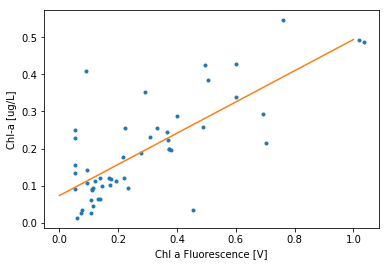

In [189]:
# Get best fit + visualize Chl-A/Fluorometer data
plt.plot(fluor_chl_df["Chl a Fluorescence [V]"], fluor_chl_df["Chl-a [ug/L]"], '.')
plt.xlabel("Chl a Fluorescence [V]")
plt.ylabel("Chl-a [ug/L]")

# Best fit line
fit_line_coeff = scipy.polyfit(fluor_chl_df["Chl a Fluorescence [V]"], fluor_chl_df["Chl-a [ug/L]"], 1) # Least squares; 1 is order
fit_line = np.poly1d(fit_line_coeff)
# print(res)
xp = np.linspace(int(fluor_chl_df["Chl a Fluorescence [V]"].min()),
                 int(fluor_chl_df["Chl a Fluorescence [V]"].max()),
                 100)
plt.plot(xp, fit_line(xp))

# TODO: Find best-fit line r value (basically error, measure of "how good" best fit line is)

In [190]:
# Apply best fit line to full dataset
hc_df["Calculated Chl-A"] = hc_df["Chl a Fluorescence [V]"].apply(fit_line)
# hc_df

In [191]:
# Filter for surface data only
hc_depth_df = hc_df[hc_df["Depth [m]"]==1]
surface_hc_df = hc_depth_df[hc_depth_df["Type"]=="C"]
surface_hc_df

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index,Station Num,Overall Day Num,Calculated Chl-A
0,S290,S290-001-HC,C,0020-02-18T01:36,175.17200,-36.357,52.0,1,22.4740,35.5891,24.5315,0.16200,217.98700,1150.0,NaN,NaN,0,1,737349,0.141415
39,S290,S290-002-HC,C,0020-02-19T20:12,174.90199,-35.786,128.0,1,21.2748,35.6089,24.8823,0.27700,220.19000,163.0,NaN,NaN,39,2,737350,0.189812
147,S290,S290-003-HC,C,0020-02-19T08:43,175.00700,-35.488,280.0,1,22.0634,35.6754,24.7134,0.23900,221.51900,0.0,NaN,NaN,147,3,737350,0.173820
386,S290,S290-004-HC,C,0020-02-20T20:58,174.83200,-35.337,206.0,1,21.3105,35.6471,24.9015,0.15900,223.38499,223.0,NaN,NaN,386,4,737351,0.140153
570,S290,S290-005-HC,C,0020-02-20T08:42,174.61400,-34.976,700.0,1,22.8972,35.8426,24.6026,0.12600,211.41100,0.0,NaN,NaN,570,5,737351,0.126265
1032,S290,S290-006-HC,C,0020-02-23T08:55,174.73500,-34.906,816.0,1,22.7021,35.8779,24.6856,0.12300,210.60400,0.0,NaN,NaN,1032,6,737354,0.125002
1623,S290,S290-007-HC,C,0020-02-24T20:43,175.40199,-34.225,1738.0,1,23.0557,35.9639,24.6488,0.09050,207.66000,588.0,NaN,NaN,1623,7,737355,0.111325
2213,S290,S290-008-HC,C,0020-02-25T20:40,175.84801,-33.603,3592.0,1,23.2882,35.8707,24.5105,0.05480,206.98399,1490.0,NaN,NaN,2213,8,737356,0.096301
2781,S290,S290-010-HC,C,0020-02-26T20:57,173.87500,-33.893,2001.0,1,23.2882,35.8707,24.5105,0.05480,206.98399,1490.0,NaN,NaN,2781,10,737357,0.096301
3349,S290,S290-011-HC,C,0020-02-26T09:16,174.05299,-33.777,1350.0,1,22.6892,35.8884,24.6972,0.12400,209.54500,0.0,NaN,NaN,3349,11,737357,0.125423


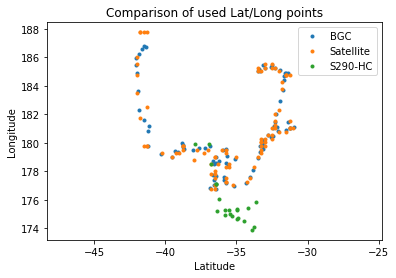

In [192]:
# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
plt.plot(surface_hc_df["Latitude [degrees_north]"], 
         surface_hc_df["Longitude [degrees_east]"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["BGC", "Satellite", "S290-HC"])
plt.title("Comparison of used Lat/Long points")

### Create Compiled HC Dataset

In [193]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "HC Lat": [],
                 "HC Long": [],
                 "HC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(surface_hc_df)): # For each station in HC dataset
    stn = surface_hc_df.iloc[i] # Get HC data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["HC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["HC Long"].append(long)
    
    # Fill in HC Chl-A data
    hc_chl = stn["Calculated Chl-A"]
    compiled_dict["HC Chl-A"].append(hc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

hc_compiled_df = pd.DataFrame(compiled_dict)
hc_compiled_df.head()

,HC Chl-A,HC Lat,HC Long,Overall Day Num,Sat Chl-A,Sat Lat,Sat Long,Station Num
0,0.141415,-36.357,175.17200,737349,0.423701,-36.27083,175.27084,1
1,0.189812,-35.786,174.90199,737350,0.249621,-35.77083,175.02084,2
2,0.173820,-35.488,175.00700,737350,0.205117,-35.52083,175.02084,3
3,0.140153,-35.337,174.83200,737351,0.249737,-35.27083,174.77084,4
4,0.126265,-34.976,174.61400,737351,0.243428,-35.02083,174.52084,5


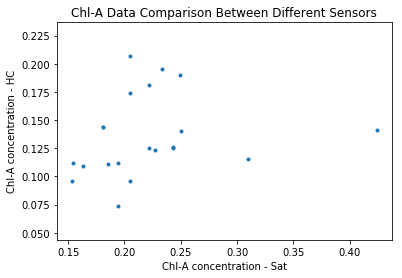

In [194]:
# TODO: Make this object-oriented
plt.axis("equal")
# plt.xlim([0,0.4])
# plt.ylim([0,0.4])
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')


plt.title("Chl-A Data Comparison Between Different Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC")


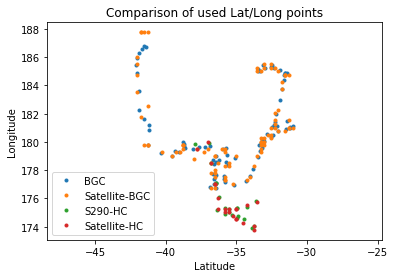

In [196]:
# TODO: Make this object-oriented
plt.plot(compiled_df["BGC Lat"], compiled_df["BGC Long"], '.')
plt.plot(compiled_df["Sat Lat"], compiled_df["Sat Long"], '.')
plt.plot(hc_compiled_df["HC Lat"], hc_compiled_df["HC Long"], '.')
plt.plot(hc_compiled_df["Sat Lat"], hc_compiled_df["Sat Long"], '.')

plt.axis("equal")
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.legend(["BGC", "Satellite-BGC", "S290-HC", "Satellite-HC"])
plt.title("Comparison of used Lat/Long points")

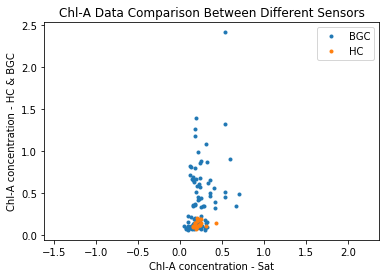

In [198]:
# TODO: Make this object-oriented
plt.axis("equal")

plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')
plt.plot(hc_compiled_df["Sat Chl-A"], hc_compiled_df["HC Chl-A"], '.')

plt.axis("equal")
plt.title("Chl-A Data Comparison Between Different Sensors")
plt.xlabel("Chl-A concentration - Sat")
plt.ylabel("Chl-A concentration - HC & BGC")
plt.legend(["BGC", "HC"])

# # TODO: Make this object-oriented
# compiled_df = compiled_df.dropna() # TODO: make this better
# plt.plot(compiled_df["Sat Chl-A"], compiled_df["BGC Chl-A"], '.')


In [73]:
bool_depth = hc_df["Depth [m]"]==1
bool_type = hc_df["Type"]=="C"

bool_filter = pd.Series()
for i in zip(bool_depth, bool_type):
    value = pd.Series(i)
    print(value.all())
#     bool_filter.add(value.all())
                     
surface_hc_df = hc_df[bool_filter]#["Calculated Chl-A"] 
# surface_hc_df[surface_hc_df["Index"] == 9262]
surface_hc_df

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
F

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

""
0
1
2
3
4
5
6
7
8
9


In [ ]:
# Scipy basics

xs = [1,2,3,4,5,6,7]
ys = [1,4,7,9,10,23,43]

print(len(xs))
print(len(ys))
line = scipy.polyfit(xs, ys, 1) # Least squares

p = np.poly1d(line)
xp = np.linspace(xs[0], xs[-1], 100)
plt.plot(xp, p(xp))
# p(1)
# import scipy.linalg
# scipy.linalg.lstsq([xs, ys], 0)

# np.
plt.plot(xs, ys, '.')

In [74]:
hc_depth_df = hc_df[hc_df["Depth [m]"]==1]
surface_hc_df = hc_depth_df[hc_depth_df["Type"]=="C"]

# bool_filter = pd.Series()
# for i in zip(bool_depth, bool_type):
#     value = pd.Series(i)
#     print(value.all())
# #     bool_filter.add(value.all())
                     
# surface_hc_df = hc_df[bool_filter]#["Calculated Chl-A"] 
# surface_hc_df[surface_hc_df["Index"] == 9262]
surface_hc_df

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH,Index
0,S290,S290-001-HC,C,0020-02-18T01:36,175.17200,-36.357,52.0,1,22.4740,35.5891,24.5315,0.16200,217.98700,1150.0,NaN,NaN,0
39,S290,S290-002-HC,C,0020-02-19T20:12,174.90199,-35.786,128.0,1,21.2748,35.6089,24.8823,0.27700,220.19000,163.0,NaN,NaN,39
147,S290,S290-003-HC,C,0020-02-19T08:43,175.00700,-35.488,280.0,1,22.0634,35.6754,24.7134,0.23900,221.51900,0.0,NaN,NaN,147
386,S290,S290-004-HC,C,0020-02-20T20:58,174.83200,-35.337,206.0,1,21.3105,35.6471,24.9015,0.15900,223.38499,223.0,NaN,NaN,386
570,S290,S290-005-HC,C,0020-02-20T08:42,174.61400,-34.976,700.0,1,22.8972,35.8426,24.6026,0.12600,211.41100,0.0,NaN,NaN,570
1032,S290,S290-006-HC,C,0020-02-23T08:55,174.73500,-34.906,816.0,1,22.7021,35.8779,24.6856,0.12300,210.60400,0.0,NaN,NaN,1032
1623,S290,S290-007-HC,C,0020-02-24T20:43,175.40199,-34.225,1738.0,1,23.0557,35.9639,24.6488,0.09050,207.66000,588.0,NaN,NaN,1623
2213,S290,S290-008-HC,C,0020-02-25T20:40,175.84801,-33.603,3592.0,1,23.2882,35.8707,24.5105,0.05480,206.98399,1490.0,NaN,NaN,2213
2781,S290,S290-010-HC,C,0020-02-26T20:57,173.87500,-33.893,2001.0,1,23.2882,35.8707,24.5105,0.05480,206.98399,1490.0,NaN,NaN,2781
3349,S290,S290-011-HC,C,0020-02-26T09:16,174.05299,-33.777,1350.0,1,22.6892,35.8884,24.6972,0.12400,209.54500,0.0,NaN,NaN,3349


In [68]:
# surface_hc_df[]
# surface_hc_df["Index"] == 0 or surface_hc_df["Index"] == 2
a = pd.Series((1,1,0))
b = pd.Series((0,0,0))
for i in zip(a,b):
    temp = pd.Series(i)
    print(temp.any())

True
True
False


In [42]:
hc_df["Type"].unique()  # What is C vs B?

array(['C', 'B'], dtype=object)

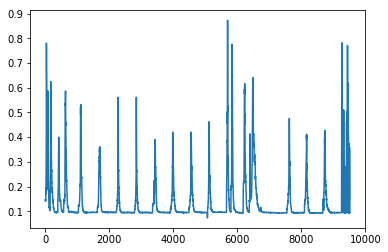

In [22]:
# Data verification
plt.plot(hc_df["Calculated Chl-A"])

In [211]:


# Find best fit line for Chl-A
# chl_data = ctd_df["Chl-a [ug/L]"].dropna()
# chl_data_idx = chl_data.index
# chl_df = ctd_df[if ctd_df["Index"] in chl_data_idx]
# chl_data

# chl_data
# chl_data_idx
# ctd_df[ctd_df.isin(chl_data_idx)["Index"]==True]
# ctd_df[ctd_data.]
# np.float64.

# ctd_df[]

In [183]:
# ctd_df["Chl-a [ug/L]"].dropna()
"""
Next steps: fix nan values in dataset (populate nans with previous value) 
collect points with calibrated chla values
make best fit line
apply best fit line to all data
plot data vs other data

refactor "days since start" to include leap years
add in timestamps with "days since start"
apply lat/long to most recent data
plot data with other data
""" 

'\nNext steps: fix nan values in dataset (populate nans with previous value) \ncollect points with calibrated chla values\nmake best fit line\napply best fit line to all data\nplot data vs other data\n'

In [ ]:
sat_df.fillna() # use pad?

In [87]:
ctd_df.fillna(method="pad") # TODO; make sure this doesn't break something

,Cruise,Station,Type,yyyy-mm-ddThh:mm:ss.sss,Longitude [degrees_east],Latitude [degrees_north],Bot. Depth [m],Depth [m],Temperature [°C],Salinity [psu],"Density [sigma-theta,Kg/m^3]",Chl a Fluorescence [V],"Oxygen,SBE43 [umol/Kg]",PAR Irradience [uE/m2/s],Chl-a [ug/L],pH
0,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,1,22.4740,35.5891,24.5315,0.16200,217.98700,1150.0,NaN,NaN
1,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,2,22.4744,35.5890,24.5314,0.16800,217.63499,816.0,NaN,NaN
2,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,3,22.5327,35.5881,24.5141,0.17900,217.65800,679.0,NaN,NaN
3,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,4,22.6162,35.5894,24.4913,0.17300,217.75999,555.0,NaN,NaN
4,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,5,22.6031,35.5902,24.4957,0.17300,217.80600,511.0,NaN,NaN
5,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,6,22.2677,35.5944,24.5944,0.16900,218.22000,465.0,NaN,NaN
6,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,7,22.1073,35.5870,24.6341,0.16800,218.47701,425.0,NaN,NaN
7,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,8,22.0566,35.5845,24.6466,0.16600,218.44400,373.0,NaN,NaN
8,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,9,22.0296,35.5837,24.6536,0.17200,218.42599,328.0,NaN,NaN
9,S290,S290-001-HC,C,0020-02-18T01:36,175.172,-36.357,52.0,10,22.0168,35.5851,24.6583,0.18100,218.55600,335.0,NaN,NaN


### Create Compiled HC Dataset

In [ ]:
compiled_dict = {"Station Num": [],
                 "Overall Day Num": [],
                 "HC Lat": [],
                 "HC Long": [],
                 "HC Chl-A": [],
                 "Sat Lat": [],
                 "Sat Long": [],
                 "Sat Chl-A": [],
                } # Initialize empty list for each variable


for i in range(0,len(hc_df)): # For each station in hydrocast dataset
    stn = bgc_df.iloc[i] # Get hydrocast data from station
    
    # Fill in Station Number
    stn_num = stn["Station Num"]
    compiled_dict["Station Num"].append(stn_num)
    
    # Fill in Day Number
    day_num = stn["Overall Day Num"]
    compiled_dict["Overall Day Num"].append(day_num)
    
    # Fill in Latitude
    lat = stn["Latitude [degrees_north]"]
    compiled_dict["BGC Lat"].append(lat)
    
    # Fill in Longitude
    long = stn["Longitude [degrees_east]"]
    compiled_dict["BGC Long"].append(long)
    
    # Fill in BGC Chl-A data
    bgc_chl = stn[BGC_CHL_A_NAME]
    compiled_dict["BGC Chl-A"].append(bgc_chl)
    
    # Compute & fill in Satellite Chl-A data
    sat_chl, sat_lat, sat_long = findNearestValue(lat, long, day_num, sat_df)
    compiled_dict["Sat Lat"].append(sat_lat)
    compiled_dict["Sat Long"].append(sat_long)
    compiled_dict["Sat Chl-A"].append(sat_chl)
               

compiled_df = pd.DataFrame(compiled_dict)
compiled_df.head()